Title: An Exploration in Earth & Word Movers Distance
Date: 6/18/17
Category: Blog
Tags: python, nlp, notebooks, text, blog

This post will be an exploration into Earth Mover's Distance as well as its application to NLP problems through Word Movers Distance.

To get started, we'll follow the benign pedagogical path of copying the Wikipedia definition:
>  The earth mover's distance (EMD) is a measure of the distance between two probability distributions over a region D. In mathematics, this is known as the Wasserstein metric. Informally, if the distributions are interpreted as two different ways of piling up a certain amount of dirt over the region D, the EMD is the minimum cost of turning one pile into the other; where the cost is assumed to be amount of dirt moved times the distance by which it is moved.

## Example ([source](http://robotics.stanford.edu/~scohen/research/emdg/emdg.html#emd))
In the picture below, imagine the `x` points are piles of dirt, and `y` are holes. The `u` and `w` values represent the 'mass' (amount) of dirt in in a pile for `x` and negative amount needing to be filled for `y` points.

![EMD Example](http://robotics.stanford.edu/~scohen/research/emdg/distns.jpg)

We calculate *cost* as the amount of dirt moved times the distance moved. If we were moving dirt from `x1` to fill `y1`, and the distance between them is 155.7 units, the cost to fill that hole is `0.23×155.7 = 35.8`. 

It is easy to generate inefficient ways to move all the dirt -- moving `x2`'s dirt to `y1` covers a longer distance and leaves less dirt in `x2` to eventually fill the remaining y holes. We want to find the most efficient way that minimizes cost. Stated formally:

> What is the minimum cumulative cost to fill all the holes `y` with dirt from `x`? 

This minimum cumulative cost Earth Movers Distance. Calculating EMD boils down to a linear programming problem (a [transportation problem](http://orms.pef.czu.cz/text/transProblem.html)) in order to find that cost. Several people smarter than me have figured out how to calculate this efficiently. Traditionally, Earth Movers Distance has [high computational complexity](http://ttic.uchicago.edu/~ssameer/Research/Papers/WEMD_CVPR08.pdf): `O(N3 * log N))`, but some other smart people have [worked hard to reduce it](http://www.ariel.ac.il/sites/ofirpele/fastemd/code/).

## Word Mover's Distance
Earth Movers Distance is pretty great on its own, but in 2015 Kusner et al. realized it could be [applied to word embeddings](http://proceedings.mlr.press/v37/kusnerb15.pdf) (like those from word2vec) in order to calculate how semantically similar two pieces of text are. Following the idea of calculating EMD in two dimensions like we covered above, an example of comparing the distance between two sentences looks something like this:

![word movers distance](https://raw.githubusercontent.com/mkusner/wmd/master/fig1.png)


## Outline
We're going to incrementally explore EMD/WMD through four use cases below.
1. Calculating EMD for a predefined example (the pile distribution above)
2. Calculating EMD for a random example
3. Calculating WMD for a predefiend example with a 2-dimensional projection of word vectors (to build visual intuition)
4. Calculating WMD for a predefined example with 300-dimensional word vectors

## 1. Calculating EMD for a predefined example

In [1]:
from random import randint
from math import sqrt
from itertools import product
import os.path

import matplotlib.pyplot as plt; plt.style.use('ggplot')
from matplotlib.patches import Rectangle
import pandas as pd
import numpy as np
from sklearn.metrics import euclidean_distances
from pyemd import emd, emd_with_flow
import gensim
from MulticoreTSNE import MulticoreTSNE as TSNE

%matplotlib inline

In order to scaffold our understanding, we'll create two objects to represent ideas in our problem space:

- An individual pile of dirt, `DirtPile`, which has:
    - A location in 2d space
    - A mass (amount) of dirt
    - An optional label
- A distribution of dirt piles, `PileDistribution`, which represents a collection "piles" or "holes". It contains one attribute:
    - A total mass
    
We're going to attempt to find the EMD from the set of piles in the image in the introduction, which is taken from an introduction to EMD you can find [here](http://robotics.stanford.edu/~scohen/research/emdg/emdg.html#emd). Our solution is an approximation since I've had to approximate the coordinate system based on the positioning.

### Define Classes

In [2]:
class DirtPile():
    def __init__(self, position, mass, label=None):
        self.position = position
        self.x, self.y = position
        self.mass = mass
        if not label:
            self.label = "{mass} @ ({x}, {y})".format(mass=self.mass, x=self.x, y=self.y)
        else:
            self.label = label
            
    def __str__(self):
        return "{mass} @ ({x}, {y})".format(mass=self.mass, x=self.x, y=self.y)

In [3]:
class PileDistribution():
    def __init__(self, *piles):
        self.piles = list(piles)
        self.masses = {tuple(p.position): p.mass for p in self.piles}
        self.mass_sum = sum(p.mass for p in self.piles)
        
    def __str__(self):
        return '\n'.join([str(pile) for pile in self.piles])
    
    def __getitem__(self, index):
        return self.piles[index]

### Build Distributions 

In [4]:
x1 = DirtPile((323, 117), .74, 'x1')
x2 = DirtPile((38, 342), .26, 'x2')

y1 = DirtPile((323, 266), .23, 'y1')
y2 = DirtPile((57, 38), .26, 'y2')
y3 = DirtPile((76, 152), .51, 'y3')

In [5]:
pd1 = PileDistribution(x1, x2)
pd2 = PileDistribution(y1, y2, y3)

### Plot Dirt Piles

In [6]:
def plot_dirt_piles(pd1, pd2, normed=True, r_scale=5000, figsize=(8,8), annotate=True):
    p1_x = [pile.x for pile in pd1.piles]
    p1_y = [pile.y for pile in pd1.piles]

    p2_x = [pile.x for pile in pd2.piles]
    p2_y = [pile.y for pile in pd2.piles]
    
    if normed:
        p1_masses = [pile.mass / pd1.mass_sum for pile in pd1.piles]
        p2_masses = [pile.mass / pd2.mass_sum for pile in pd2.piles]
    else:
        p2_masses = [pile.mass for pile in pd2.piles]
        p1_masses = [pile.mass for pile in pd1.piles]


    plt.figure(figsize=figsize)
    plt.scatter(x=p1_x, y=p1_y, s=[r_scale*m for m in p1_masses], c='r', alpha=0.5)
    plt.scatter(x=p2_x, y=p2_y, s=[r_scale*m for m in p2_masses], c='b', alpha=0.5)

    if annotate:
        for pile in pd1.piles:
            plt.annotate(xy=[pile.x, pile.y], s=pile.label, textcoords='data')
        for pile in pd2.piles:
            plt.annotate(xy=[pile.x, pile.y], s=pile.label, textcoords='data')
                

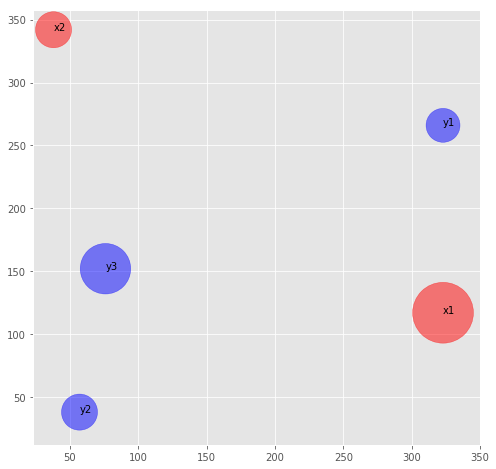

In [7]:
plot_dirt_piles(pd1, pd2)

### Process Data for EMD Calculation
We're going to use the `pyemd` library. Getting the data in the correct format to calculate EMD is a bit of a chore. We need to generate what's called a `signature` for each pile distribution. A signature is another way to represent data we have above. To build a signature, we need the set of all points (union) between the two distributions and the mass from each distribution for that point.

We're also going to normalize the signatures so that the masses sum to 1. In this specific example they already do, but when we move on to WMD we'll want to make sure they're normalized.

In [8]:
def generate_signatures(piledist1, piledist2, normalize=False):
    
    # build unique list of pile positions
    # sorted by distance from the origin
    all_piles = piledist1.piles + piledist2.piles
    positions = sorted(list(set(pile.position for pile in all_piles)),
                       key=lambda x: sqrt(x[0]**2 + x[1]**2))
    
    # build signatures
    # check if the distribution has a mass at this position or return 0
    p1_signature = []
    p2_signature = []
    for position in positions:
        p1_location_mass = piledist1.masses.get(position, 0)
        p2_location_mass = piledist2.masses.get(position, 0)
        p1_signature.append(p1_location_mass)
        p2_signature.append(p2_location_mass)
    if normalize:
        p1_signature = [mass / sum(p1_signature) for mass in p1_signature]
        p2_signature = [mass / sum(p2_signature) for mass in p2_signature]
    
    return positions, p1_signature, p2_signature

In [9]:
positions, p1_signature, p2_signature = generate_signatures(pd1, pd2, normalize=True)

In [10]:
print("Pile 1 Signature:")
for position, mass in zip(positions, p1_signature):
    print("Position:", position, "Mass:", mass)
    
print()
print("Pile 2 Signature:")
for position, mass in zip(positions, p2_signature):
    print("Position:", position, "Mass:", mass)

Pile 1 Signature:
Position: (57, 38) Mass: 0.0
Position: (76, 152) Mass: 0.0
Position: (323, 117) Mass: 0.74
Position: (38, 342) Mass: 0.26
Position: (323, 266) Mass: 0.0

Pile 2 Signature:
Position: (57, 38) Mass: 0.26
Position: (76, 152) Mass: 0.51
Position: (323, 117) Mass: 0.0
Position: (38, 342) Mass: 0.0
Position: (323, 266) Mass: 0.23


So the signatures themselves are the mass values indexed by the unique set of locations between the two distributions.

### Calculate Distances
Now that we have the set of all coordiatnes between the two distributions, we're going to calculate the distance between each pair of coordinates.

In [11]:
dist = euclidean_distances(positions, positions)
print(pd.DataFrame(dist.round(1), index=positions, columns=positions))

            (57, 38)  (76, 152)  (323, 117)  (38, 342)  (323, 266)
(57, 38)         0.0      115.6       277.5      304.6       350.3
(76, 152)      115.6        0.0       249.5      193.8       272.0
(323, 117)     277.5      249.5         0.0      363.1       149.0
(38, 342)      304.6      193.8       363.1        0.0       295.0
(323, 266)     350.3      272.0       149.0      295.0         0.0


### Calculate Earth Movers Distance
`pyemd` requires that the input arrays be of type `np.double`, so we're going to cast them as such. After that, we'll just use the `emd_with_flow` to calculate the EMD value as well as take a look at the flow, which tells us how much earth moved where under the optimial solution.

In [12]:
def calculate_emd(signature_1, signature_2, distance_matrix):
    first_signature = np.array(signature_1, dtype=np.double)
    second_signature = np.array(signature_2, dtype=np.double)
    distances = np.array(distance_matrix, dtype=np.double)
    emd, flow = emd_with_flow(first_signature, second_signature, distances)
    flow = np.array(flow)
    return emd, flow

In [13]:
emd, flow = calculate_emd(p1_signature, p2_signature, dist)

In [14]:
print("EMD: {0:.2f}".format(emd))

EMD: 219.16


In [15]:
print("Flow:\n", pd.DataFrame(flow, index=positions, columns=positions))

Flow:
             (57, 38)  (76, 152)  (323, 117)  (38, 342)  (323, 266)
(57, 38)        0.00       0.00         0.0        0.0        0.00
(76, 152)       0.00       0.00         0.0        0.0        0.00
(323, 117)      0.26       0.25         0.0        0.0        0.23
(38, 342)       0.00       0.26         0.0        0.0        0.00
(323, 266)      0.00       0.00         0.0        0.0        0.00


### Plot Solution
The flow matrix is helpful in understanding the solution since we can trace how masses were moved between locations. A visualization of the piles and flow will also help illustrate this specific solution.

In [16]:
def plot_emd_solution(pd1, pd2, positions, emd, flow, normed=True, r_scale=5000, figsize=(8,8), annotate=True):
    p1_x = [pile.x for pile in pd1.piles]
    p1_y = [pile.y for pile in pd1.piles]

    p2_x = [pile.x for pile in pd2.piles]
    p2_y = [pile.y for pile in pd2.piles]
    
    if normed:
        p1_masses = [pile.mass / pd1.mass_sum for pile in pd1.piles]
        p2_masses = [pile.mass / pd2.mass_sum for pile in pd2.piles]
    else:
        p2_masses = [pile.mass for pile in pd2.piles]
        p1_masses = [pile.mass for pile in pd1.piles]
        
    flow_measures = []
    for to_pos_ix, from_pos_ix in zip(*np.nonzero(flow)):
        to_pos = positions[to_pos_ix]
        from_pos = positions[from_pos_ix]
        measure = {'to' : to_pos, 'from' : from_pos,
                   'xs' : (to_pos[0], from_pos[0]),
                   'ys' : (to_pos[1], from_pos[1]),
                   'value' : flow[to_pos_ix, from_pos_ix]}
        flow_measures.append(measure)

    plt.figure(figsize=figsize)

    plt.scatter(x=p1_x, y=p1_y, s=[r_scale*m for m in p1_masses], c='r', alpha=0.8)   
    plt.scatter(x=p2_x, y=p2_y, s=[r_scale*m for m in p2_masses], c='b', alpha=0.8)

    for measure in flow_measures:
        plt.plot([*measure['xs']], [*measure['ys']],
                 color='black', lw=measure['value']*r_scale/100, alpha=0.7, solid_capstyle='round')

    plt.title("Example Earth Movers Distance Solution\n EMD: {0:.2f}".format(emd));

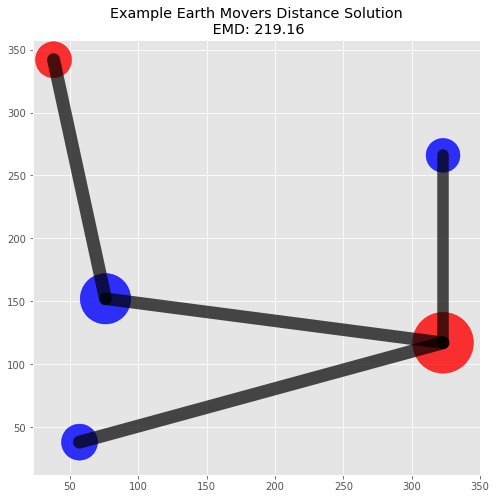

In [17]:
plot_emd_solution(pd1, pd2, positions, emd, flow)

## 2. Calculating EMD for a random example
For fun, let's see what a larger problem with EMD looks like. We'll simulate two random distributions with 100 dirt piles each. Each point will be randomly placed on a 100 by 100 plane with random mass from 25 to 100.

In [18]:
big_piles1 = [DirtPile((randint(0, 100), randint(0, 100)), randint(25, 100)) for _ in range(0, 100)]
big_piles2 = [DirtPile((randint(0, 100), randint(0, 100)), randint(25, 100)) for _ in range(0, 100)]

big_pd1 = PileDistribution(*big_piles1)
big_pd2 = PileDistribution(*big_piles2)

In [19]:
big_positions, big_p1_signature, big_p2_signature = generate_signatures(big_pd1, big_pd2, normalize=True)

In [20]:
big_distances = euclidean_distances(big_positions, big_positions)

In [21]:
big_emd, big_flow = calculate_emd(big_p1_signature, big_p2_signature, big_distances)

### Visually Analyzing Cost
It would be odd if mass had to be moved from the point `(0, 0)` to `(100, 100)`, since that would mean there are no closer piles between the corners of our plane. Since the index generated for the signature is the set of positions sorted by distance from the origin, flow should occur near points next to each other in our index. This also means that the more a flow is off diagonal, the more distance will impact the total cost (at least for these simulated distributions).

We can visualize the cost matrix by multiplying the flow (how much mass was moved) by the distance

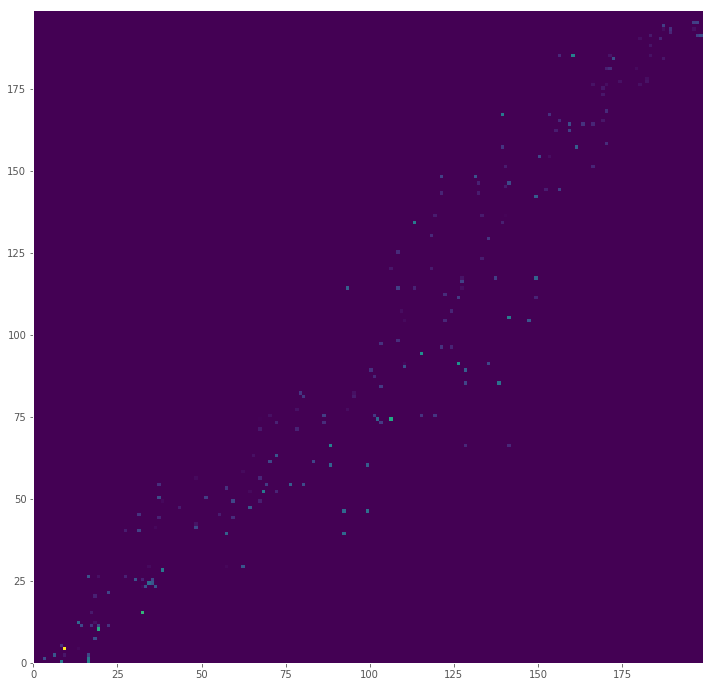

In [22]:
big_cost = pd.DataFrame((big_flow * big_distances), index=big_positions, columns=big_positions)
plt.figure(figsize=(12,12), dpi=72)
plt.pcolor(big_cost, cmap='viridis')
plt.show()

#### Most Costly Move
Below we calculate which move incurred the highest cost. We'll also point it out in our final visualization to verify.

In [23]:
most_costly_from = big_cost.max(axis=0).idxmax()
most_costly_from_ix = big_positions.index(most_costly_from)
most_costly_to = big_cost.max(axis=1).idxmax()
most_costly_to_ix = big_positions.index(most_costly_to)
most_costly_mass = big_cost.values.max().round(2)

most_costly_info = (most_costly_from_ix, most_costly_from, most_costly_mass, most_costly_to_ix, most_costly_to)

print("Most Costly Move:")
print("Index: [{}], Position: {} ".format(most_costly_from_ix, most_costly_from))
print("\t\t↓↓")
print("\t    cost: {}".format(most_costly_mass))
print("\t\t↓↓")
print("Index: [{}], Position: {} ".format(most_costly_to_ix, most_costly_to))


Most Costly Move:
Index: [9], Position: (14, 27) 
		↓↓
	    cost: 0.26
		↓↓
Index: [4], Position: (24, 5) 


### Plot Solution

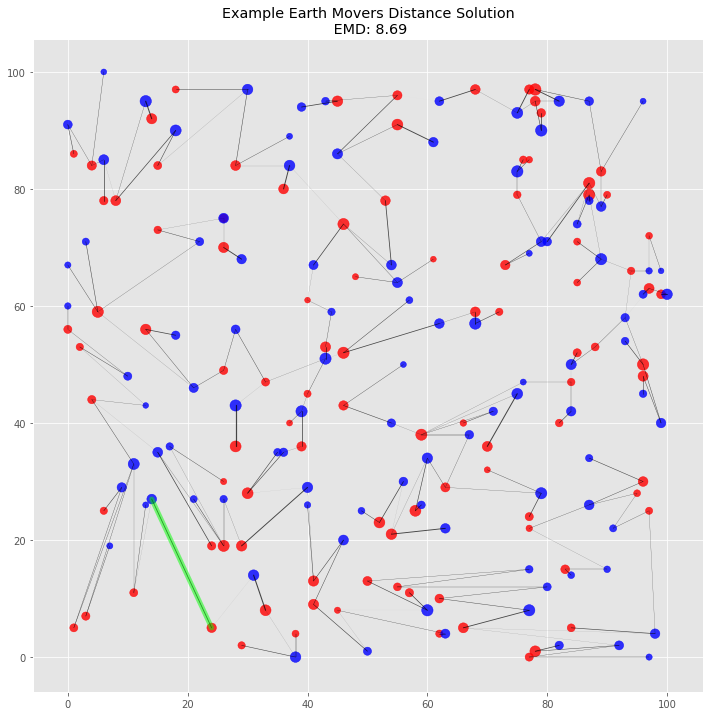

In [24]:
plot_emd_solution(big_pd1, big_pd2, big_positions, big_emd, big_flow, figsize=(12, 12), r_scale=8000)
# highlight most costly move
plt.plot([most_costly_from[0], most_costly_to[0]], [most_costly_from[1], most_costly_to[1]],
         color='lime', lw=5, alpha=0.5, solid_capstyle='round');

This visualization of the solution gives us additional visual confirmation that the algorithm works. There are no piles that need to travel across the plane. Indeed, it's possible to see clusters of flow grouped together by proximal piles. The highlighted most costly move makes sense: it's one large pile to another over one of the longer distances between the two piles.

## 3. Calculating Word Movers Distance for a predefiend example with a 2-dimensional projection of word vectors

We're now going to attempt to build some intuition around what Word Movers Distance is. To start, imagine we have two sentences for which we want to calculate their similarity. Pulling from the original WMD paper, let's use the following two sentences:

- **Obama speaks** to the **media** in **Illinois**
- The **President greets** the **press** in **Chicago**

The bolded words are the words we'll actually use (non-stopwords). This is a great example for WMD because the sentences are about the same concept, but contain no similar words, so traditional approaches like TFIDF won't work.

In EMD we calculate the cost of moving dirt between two distributions of dirt piles. In WMD, the parallel ideas to EMD are:

- Pile Distribution → A Sentence / Bag of Words
- Dirt Pile Mass → Normalized Count of word in sentence
- Dirt Pile Location → A single word vector in a word embedding

We have our two pile distributions (sentences) and masses (counts of words), and our locations will be provided by an existing word embedding. We'll be using the Google News word vectors. We're going to subset the full word embedding of 3 billion words to the 333,333 most common english words [[ref](http://norvig.com/ngrams/)]. 

### Building Intuition through Visualization
The original vectors are in 300-dimensions, so we're going to first project down to 2-dimensions using TSNE to make it easier to visualize and compare to the models we've built above. This will change the results for WMD, but will help with the visual comparison.

In [25]:
def read_1w_corpus(name, sep="\t"):
    for line in open(name):
        yield line.split(sep)

In [26]:
print("Loading GoogleNews Vectors")
%time model = gensim.models.KeyedVectors.load_word2vec_format('/Users/pbaumgartner/data/GoogleNews-vectors-negative300.bin.gz', binary=True)
vocabulary = set(model.vocab)
relevant_words = [word for (word, count) in read_1w_corpus('/Users/pbaumgartner/data/count_1w.txt') if word in vocabulary]
model_reduced = model[[w for w in relevant_words]]

Loading GoogleNews Vectors
CPU times: user 2min 15s, sys: 5.44 s, total: 2min 20s
Wall time: 2min 21s


The Full TSNE of the word vectors took around 22min on my computer, so I've saved the projection. If you run this notebook, the cell below will rebuild the projection for you.

In [27]:
if not os.path.isfile('w2v_tsne.csv'):
    tsne = TSNE(n_components=2, n_jobs=-1, random_state=666)
    print("Performing TSNE on GoogleNews Vectors")
    %time tsne_vectors = tsne.fit_transform(model_reduced.astype(np.float64)) 
    d = pd.DataFrame(tsne_vectors, columns=['c1', 'c2'])
    d['word'] = relevant_words
    d.to_csv('w2v_tsne.csv')
else:
    d = pd.read_csv('w2v_tsne.csv', index_col=0)

### Flag the embeddings that correspond to the tokens in our sentences

In [28]:
# Obama speaks to the media in Illinois 
sentence1_words = ['obama', 'speaks', 'media', 'illinois']

# The President greets the press in Chicago. 
sentence2_words = ['president', 'greets', 'press', 'chicago']

In [29]:
d['sentence1'] = d['word'].isin(sentence1_words)
d['sentence2'] = d['word'].isin(sentence2_words)

### Generate attributes for plotting

In [30]:
def colors(row):
    if row['sentence1']:
        return '#FF0000'
    if row['sentence2']:
        return '#0000FF'
    else:
        return '#8FBC8F'

In [31]:
def sizes(row):
    if row['sentence1'] or row['sentence2']:
        return 100
    else:
        return 1

In [32]:
d['colors'] = d.apply(colors, axis=1)
d['sizes'] = d.apply(sizes, axis=1)

### Subset the dataset to make the plotting easier

In [33]:
d_normal = d.loc[lambda x: (x['sentence1'] == False) & (x['sentence2'] == False)]
d_sentences = d.loc[lambda x: (x['sentence1'] == True) | (x['sentence2'] == True)]

### Calculate Axis bounds for zoomed plot

In [34]:
xmin, xmax, ymin, ymax = (d_sentences['c1'].min()-1,
                          d_sentences['c1'].max()+1,
                          d_sentences['c2'].min()-1,
                          d_sentences['c2'].max()+1)

d_normal_limited = d_normal.loc[lambda x: (
    (x['c1'] > xmin) &
    (x['c1'] < xmax) &
    (x['c2'] > ymin) &
    (x['c2'] < ymax))]

### Plot Sentence Word embeddings with full word embedding overlay
The plot below will highlight the positions of the word embeddings from words contained in our two sentences. We'll also overlay any additional vectors in the same location just to show the density of word vectors in this projection.

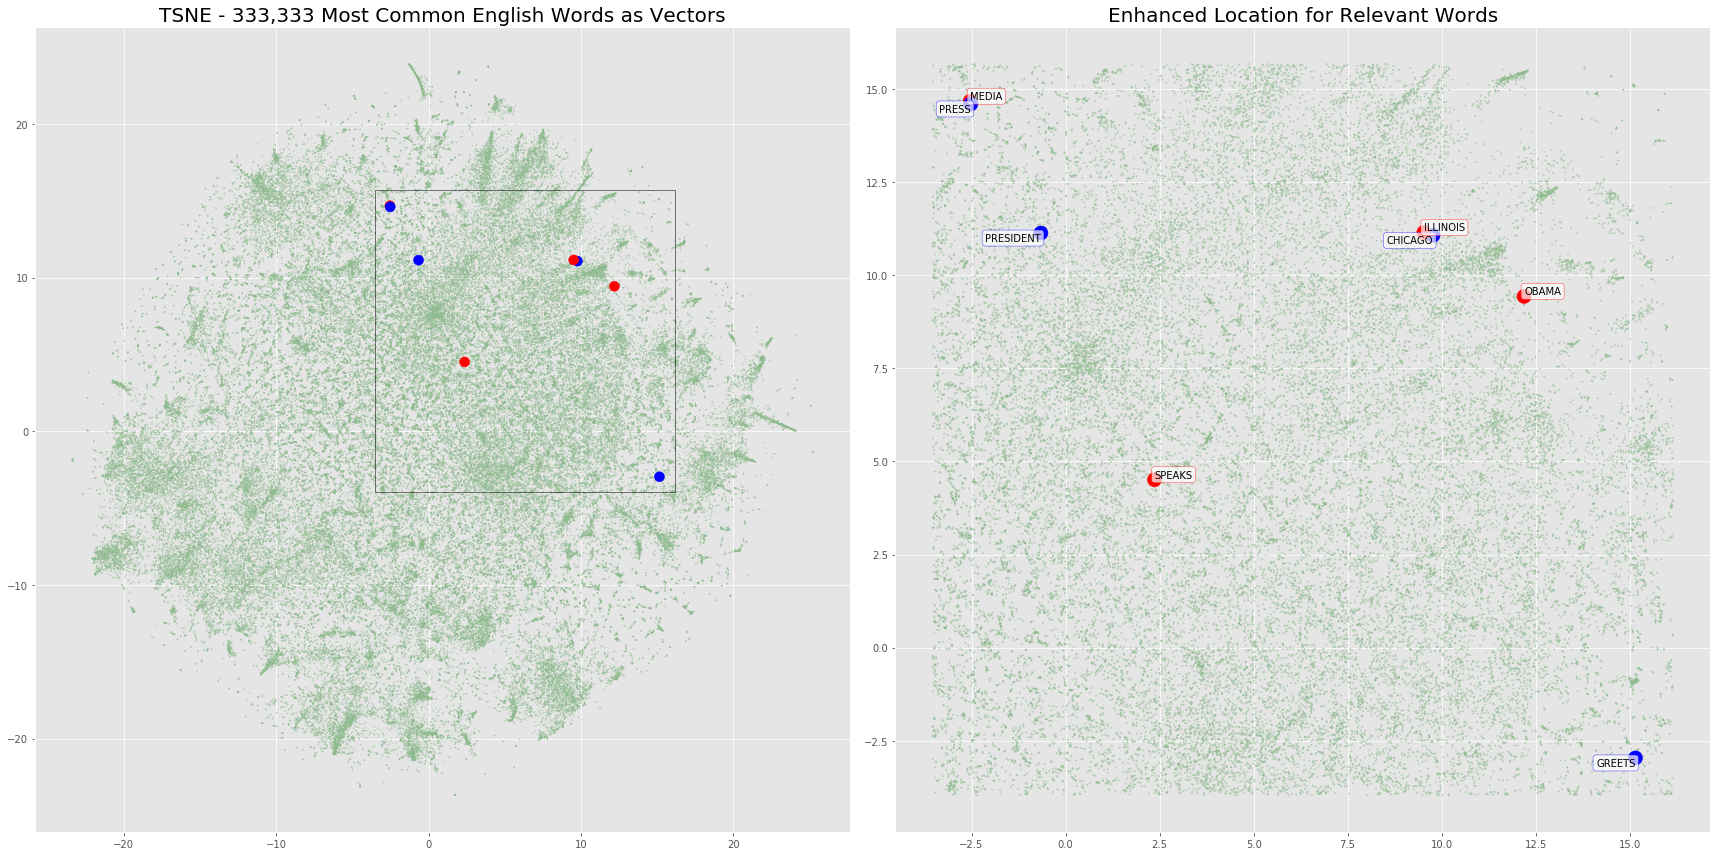

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12))

ax1.scatter(x=d_normal['c1'], y=d_normal['c2'], c=d_normal['colors'], alpha=.5, s=d_normal['sizes'], );
ax1.scatter(x=d_sentences['c1'], y=d_sentences['c2'], c=d_sentences['colors'], alpha=1, s=d_sentences['sizes'], );
ax1.set_title('TSNE - 333,333 Most Common English Words as Vectors', fontsize=20)
box = Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, fill=False, edgecolor='black')
ax1.add_patch(box)

ax2.scatter(x=d_normal_limited['c1'], y=d_normal_limited['c2'], c=d_normal_limited['colors'], alpha=.5, s=d_normal_limited['sizes'] + 1, );
ax2.scatter(x=d_sentences['c1'], y=d_sentences['c2'], c=d_sentences['colors'], alpha=1, s=d_sentences['sizes'] + 100, );
ax2.set_title('Enhanced Location for Relevant Words', fontsize=20)

for word in d_sentences.to_dict(orient='rows'):
    if word['sentence2']:
        ax2.annotate(xy=[word['c1'], word['c2']],
                     s=word['word'].upper(),
                     textcoords='data',
                     horizontalalignment='right',
                    verticalalignment='top',
                     bbox=dict(boxstyle="round", fc="w", ec="b", alpha=0.7))
    else:
        ax2.annotate(xy=[word['c1'], word['c2']] ,
                     s=word['word'].upper(),
                     textcoords='data',
                    horizontalalignment='left',
                    verticalalignment='bottom',
                     bbox=dict(boxstyle="round", fc="w", ec="r", alpha=0.7))
fig.tight_layout()

### Build Components to calculate WMD

In [36]:
sentence1_piles = []
sentence2_piles = []

for word in d_sentences.to_dict(orient='rows'):
    if word['sentence1']:
        sentence1_piles.append(DirtPile((word['c1'], word['c2']), 1, word['word']))
    else:
        sentence2_piles.append(DirtPile((word['c1'], word['c2']), 1, word['word']))
        
sentence1_dist = PileDistribution(*sentence1_piles)
sentence2_dist = PileDistribution(*sentence2_piles)

In [37]:
sentence_positions, sentence_p1_signature, sentence_p2_signature = generate_signatures(sentence1_dist, sentence2_dist, normalize=True)

In [38]:
sentence_dist = euclidean_distances(sentence_positions, sentence_positions)

sentence_emd, sentence_flow = emd_with_flow(np.array(sentence_p1_signature), np.array(sentence_p2_signature), sentence_dist)

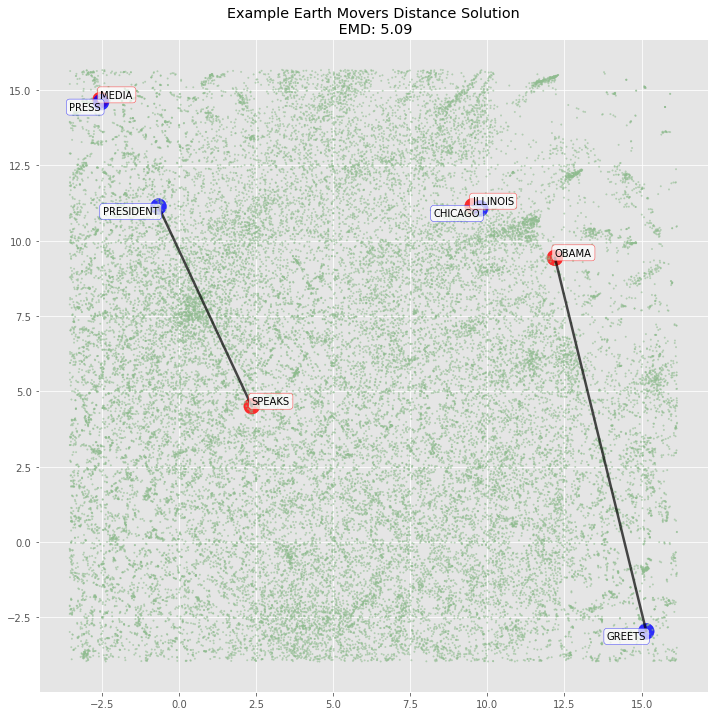

In [39]:
plot_emd_solution(sentence1_dist, sentence2_dist, sentence_positions, sentence_emd, np.array(sentence_flow), figsize=(12, 12), r_scale=1000)

plt.scatter(x=d_normal_limited['c1'], y=d_normal_limited['c2'], c=d_normal_limited['colors'], alpha=.5, s=d_normal_limited['sizes'] + 1, );

for word in d_sentences.to_dict(orient='rows'):
    if word['sentence2']:
        plt.annotate(xy=[word['c1'], word['c2']],
                     s=word['word'].upper(),
                     textcoords='data',
                     horizontalalignment='right',
                    verticalalignment='top',
                     bbox=dict(boxstyle="round", fc="w", ec="b", alpha=0.7))
    else:
        plt.annotate(xy=[word['c1'], word['c2']] ,
                     s=word['word'].upper(),
                     textcoords='data',
                    horizontalalignment='left',
                    verticalalignment='bottom',
                     bbox=dict(boxstyle="round", fc="w", ec="r", alpha=0.7))

## 4. Calculating WMD for a predefined example with 300-dimensional word vectors
We're going to remove the scaffolding we used to understand EMD in two dimensions and calculate EMD using the full 300-dimensional vectors. There's not much mechanical difference here: we still need to generate the signatures using the unique set of words between the two sentences and calculate the distances between each word in that set. However, distances are calculated over 300 dimensions rather than two.

Since the two dimensional TSNE representation didn't map the variables as we would expect (it missed Obama → President for example), our hypothesis is that the 300 dimensional vectors will be able to fully represent the semantics of each word and the mapping will hold. We verify below.

In [40]:
# Normalize word vectors for comparison to original paper
%time model.init_sims(replace=True)

CPU times: user 18.5 s, sys: 2.37 s, total: 20.8 s
Wall time: 20.9 s


In [41]:
w2v_sentence1_piles, w2v_sentence2_piles = [], []

for word in sentence1_words:
    w2v_sentence1_piles.append({'vector' : model[word], 'mass' : 0.25, 'label' : word})
for word in sentence2_words:
    w2v_sentence2_piles.append({'vector' : model[word], 'mass' : 0.25, 'label' : word})
    
all_piles = w2v_sentence1_piles + w2v_sentence2_piles

In [42]:
w2v_p1_signature = [0.25, 0.25, 0.25, 0.25, 0, 0, 0, 0]
w2v_p2_signature = [0, 0, 0, 0, 0.25, 0.25, 0.25, 0.25]

In [43]:
w2v_distances = euclidean_distances([i['vector'] for i in all_piles], [i['vector'] for i in all_piles])

In [44]:
w2v_emd, w2v_flow = calculate_emd(w2v_p1_signature, w2v_p2_signature, w2v_distances)

In [45]:
print("W2V 300-Dimension EMD:", round(w2v_emd, 2))

W2V 300-Dimension EMD: 1.02


### Construct Flow Matrix to understand where masses traveled

In [46]:
flow_df = pd.DataFrame(w2v_flow, index=[i['label'] for i in all_piles], columns=[i['label'] for i in all_piles])
flow_df

,obama,speaks,media,illinois,president,greets,press,chicago
obama,0.0,0.0,0.0,0.0,0.25,0.00,0.00,0.00
speaks,0.0,0.0,0.0,0.0,0.00,0.25,0.00,0.00
media,0.0,0.0,0.0,0.0,0.00,0.00,0.25,0.00
illinois,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.25
president,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00
greets,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00
press,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00
chicago,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00


Above we verify that the solution is the same as it is in the original paper, and follows our intuition about which pairs of words were most similar. The matches were:
    
- President → Obama
- greets → speeks
- press → media
- Chicago → Illinois

### Calculate Cost Matrix
`cost = distance × mass`

In [47]:
# first put distance matrix in a DF
dist_df = pd.DataFrame(w2v_distances, index=[i['label'] for i in all_piles], columns=[i['label'] for i in all_piles])
cost_df = (flow_df * dist_df)
cost_df

,obama,speaks,media,illinois,president,greets,press,chicago
obama,0.0,0.0,0.0,0.0,0.33452,0.000000,0.000000,0.000000
speaks,0.0,0.0,0.0,0.0,0.00000,0.244525,0.000000,0.000000
media,0.0,0.0,0.0,0.0,0.00000,0.000000,0.223237,0.000000
illinois,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.215182
president,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000
greets,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000
press,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000
chicago,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000


### Verify total cost == EMD

In [48]:
# using np.isclose due to rounding
np.isclose(w2v_emd, cost_df.values.sum())

True

## Summary
Through this notebook we've gone from a basic Earth Movers Distance example in two dimensions to a full Word Movers Distance examples with the 300-dimensional `word2vec` vectors. Earth Movers Distance is an interesting problem on its own, and the NLP application of Word Movers Distance helps solve problems in calculating the semantic similarity of documents with no shared vocabulary.

### Python Implementations
Both [textacy](http://textacy.readthedocs.io/en/latest/api_reference.html#textacy.similarity.word_movers) and [gensim](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.wmdistance) have implementations of Word Movers Distance you can use. Gensim will require you to load (or build) a word embedding first, and I believe textacy will use the GloVe vectors from spaCy by default.

### Related Resources
- [WMD Tutorial](https://markroxor.github.io/gensim/static/notebooks/WMD_tutorial.html)
- [Word Movers Distance in Python](http://vene.ro/blog/word-movers-distance-in-python.html)
- [Slack Maestro: Helping Users Stay on Topic](http://blog.fastforwardlabs.com/2017/05/30/Slack-Maestro-Helping-Users-Stay-on-Topic.html)